# VGG11
- Cifar10
- Notebooks@Azure
- Python 3.8.5
- 仅使用d2l库用于创建图表
- VGG block块中加入BatchNormlization并激活Relu函数
- 加入dropout
- 使用随机梯度下降（SGD）优化器、余弦退火学习率调度器、权重衰减
- 使用分类器：分类器中包含了若干线性层和激活函数，用于将特征向量映射到类别预测。
- 交叉熵损失函数
- Cuda加速
- 使用pytorch、torchvision内置方法加载数据集
- 使用sklearn.metrics模块获得测试准确率和F1得分
- 使用自定义的train()函数
- 为什么要重写Train():
    d2l中内置的train_ch13已经能满足需求但是没法再堆叠打印出F1得分并且trainloss在过程中一直是趋近于0不符合实际我觉得存在bug并且使用自定义的Train()可以更自由的调节lr，在需要查看整个过程中的数据在GoogleNet中可以查看所有的数据做出更精细化的调整
----

#### 数据增强
- 从输入图像中随机裁剪一个大小为 32x32 的部分，并进行 4 像素的填充。
- 以 0.5 的概率随机水平翻转图像。
- 通过减去每个通道的均值并除以标准差值，对张量图像进行归一化。提供的均值和标准差值对应于 CIFAR-10 数据集的 RGB 通道。

#### 模型代码介绍
- 定义了一个名为VGGBlock的VGG模型块，以及一个名为VGG11的完整VGG11模型。

- VGGBlock是VGG模型中的一个基本模块，用于构建VGG11模型的特征提取器部分。它接受输入的通道数（in_channels）、输出的通道数（out_channels）和卷积层数量（num_convs）作为参数。在初始化方法中，它通过循环创建一系列的卷积层（Conv2d）、批归一化层（BatchNorm2d）和ReLU激活函数，构成一个卷积块。最后，它添加了一个最大池化层（MaxPool2d）。在前向传播方法中，输入数据将通过这个卷积块进行特征提取。

- VGG11是基于VGGBlock构建的完整VGG11模型。它的特征提取器部分包含了5个VGGBlock模块，每个模块具有不同的输入通道数、输出通道数和卷积层数量。在初始化方法中，它定义了特征提取器部分、自适应平均池化层（AdaptiveAvgPool2d）和分类器部分。在前向传播方法中，输入数据将通过特征提取器部分进行特征提取，然后通过自适应平均池化层进行空间平均池化，最后通过展平操作将特征展平为一维张量。展平后的特征将通过分类器部分进行分类预测。

-----
#### Code

- 导入必要库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import d2l
from sklearn.metrics import accuracy_score, f1_score

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 创建VGG块以及VGG11模型

In [4]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            VGGBlock(3, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



- 数据预处理

In [5]:
transform_train=transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

- 加载数据集并进行数据增强

In [6]:

batch_size = 128#批量大小
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)#加载CIFAR-10数据集，如果数据集不存在则会下载到./data文件夹下
train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)#对训练集进行数据预处理
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)#对测试集进行数据预处理
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)#

Files already downloaded and verified
Files already downloaded and verified


- GPU设备以及模型创建

In [7]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

net = VGG11()
net = net.to(device)

- 设置训练轮数以及定义SGD优化器、损失函数、学习率调度器（余弦退火）并进行训练

Epoch [280/280], Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 0.9999, Test Loss: 0.3602, Test Acc: 0.9358, Test F1: 0.9312


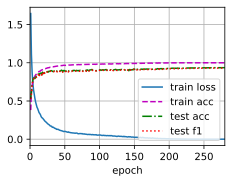

In [8]:
num_epochs = 280

optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)#学习率策略
criterion = nn.CrossEntropyLoss()
def train(net, trainloader, testloader, num_epochs, optimizer, criterion, device, scheduler=None):
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc', 'test f1'])

    for epoch in range(num_epochs):
        net.train()  # 将模型设置为训练模式
        train_loss, train_acc, train_f1 = 0.0, 0.0, 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
            train_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_f1 /= len(trainloader)

        # 在测试集上验证模型性能
        net.eval()  # 将模型设置为评估模式
        test_loss, test_acc, test_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                test_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
                test_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        test_loss /= len(testloader)
        test_acc /= len(testloader)
        test_f1 /= len(testloader)

        # 输出每个 epoch 的结果
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

        if scheduler:
            if scheduler.__module__ == 'torch.optim.lr_scheduler':
                # 使用 PyTorch 内置的学习率调度器
                scheduler.step()
            else:
                # 使用自定义的学习率调度器
                for param_group in optimizer.param_groups:
                    param_group['lr'] = scheduler(epoch)

        animator.add(epoch+1, (train_loss, train_acc, test_acc, test_f1))
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))
train(net, train_iter, test_iter, num_epochs, optimizer, criterion, device, scheduler)

#### train( )函数
`train()`函数是一个基于PyTorch的函数，用于训练神经网络模型。它需要以下参数：
* `net`： 要训练的神经网络模型。
* `trainloader`： 训练数据加载器。
* `testloader`： 测试数据加载器。
* `num_epochs`： 训练的历时数。
* `optimizer`： 训练时使用的优化器。
* `criterion`： 训练中使用的损失函数。
* `device`： 训练模型的设备（CPU或GPU）。
* `scheduler`： 学习率调度器（可选）。

函数首先调用 `d2l`中`Animator`类创建一个对象来绘制图像跟踪训练的进展。然后，进入一个指定的轮数的循环。在每轮中，该函数做以下工作：

1. 将模型设置为训练模式。
2. 遍历训练数据加载器，对每批数据进行前向传递和后向传递。
3. 使用优化器更新模型参数。
4. 计算训练损失和准确性。
5. 在测试数据上评估模型，并计算测试损失和准确性，F1得分(用于评估模型训练的效果)
6. 将所得的损失和准确率、F1在图像中更新

若使用了一个学习率调度器，`train`函数将在每个历时结束时更新学习率。

`train()`函数打印出训练损失和准确率，以及测试损失和准确率。

----------

### Result
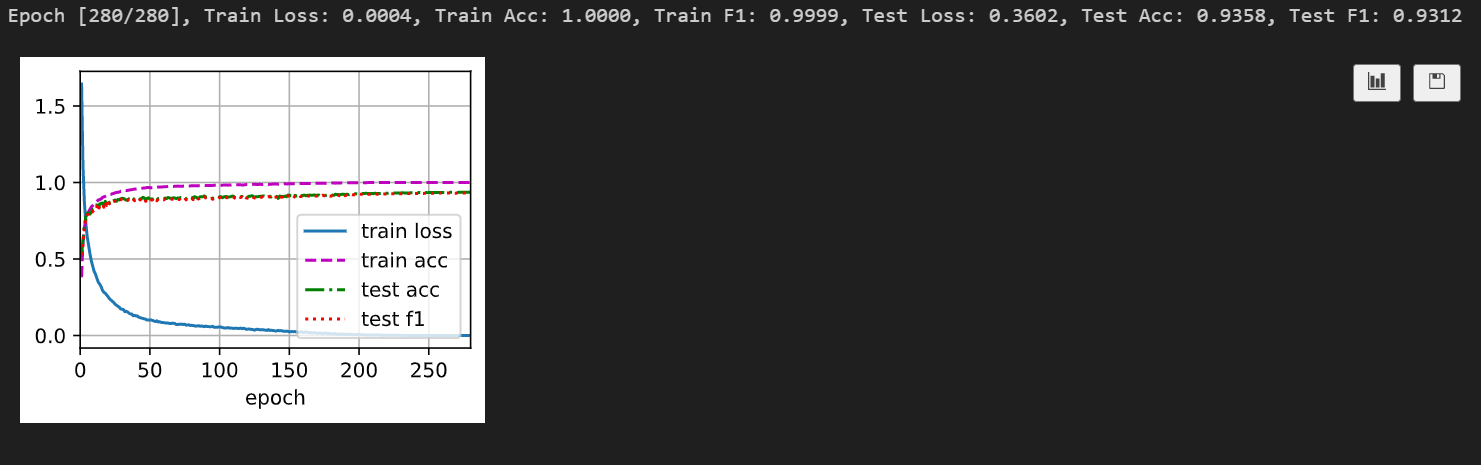
`Epoch [280/280], Train Loss: 0.0004, Train Acc: 1.0000, Test Loss: 0.3602, Test Acc: 0.9358`

#### 参数说明
参数说明如下：

- Learning Rate（学习率）：0.01。
- Batch Size（批大小）：128。

- Epochs（训练轮数）：280。

- Dropout：0.4。 Dropout 为 0.4，在训练过程中每个神经元的输出有 40% 的概率被置为零。

- Weight Decay（权重衰减）：5e-4。

- Momentum（动量）：0.9。动量系数为 0.9，当前的梯度更新方向受到 90% 的动量影响。